In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as PCA
#all the algorithms needed for later
from sklearn.neighbors import KNeighborsClassifier as KNClass
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier #Neural Network

#needed for the plots
from sklearn.metrics import roc_curve, auc
import sys
%matplotlib inline

dfPollutersSent = pd.read_csv('created_data/polSentFreq.csv', index_col=0)
dfLegitSent = pd.read_csv('created_data/legSentFreq.csv', index_col=0)



In [2]:
def getROC(df1, df2):
    #section one, prepare data for the learning algorithms
    #divide into equal sections, take 10 total sets from each dataset
    #give proper classifications for each
    foldData = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
    
    #add in a parameter for the number of folds to use
    
    segDF1 = int(len(df1)/10)
    segDF2 = int(len(df2)/10)
    #arrays with the starting points for each fold
    df1Segs = [0*segDF1, 1*segDF1, 2*segDF1, 3*segDF1, 4*segDF1, 5*segDF1, 6*segDF1, 7*segDF1, 8*segDF1, 9*segDF1]
    df2Segs = [0*segDF2, 1*segDF2, 2*segDF2, 3*segDF2, 4*segDF2, 5*segDF2, 6*segDF2, 7*segDF2, 8*segDF2, 9*segDF2]
    
    for i in range(len(df1Segs)):
        #get the fold to fit on
        try:
            fitDF1 = df1[df1Segs[i]:df1Segs[i+1]]
            fitDF2 = df2[df2Segs[i]:df2Segs[i+1]]
            
            predDF1 = pd.concat([df1[:df1Segs[i]], df1[df1Segs[i+1]:]])
            predDF2 = pd.concat([df2[:df2Segs[i]], df2[df2Segs[i+1]:]])
        except IndexError: #Only for the last fold
            fitDF1 = df1[df1Segs[i]:]
            fitDF2 = df2[df2Segs[i]:]
            
            predDF1 = df1[:df1Segs[i]]
            predDF2 = df2[:df2Segs[i]]
            
        #use the DF to get the data
        fitData, fitCls = machLearnData(fitDF1, fitDF2)
        preData, preCls = machLearnData(predDF1, predDF2)
    
        #second one apply all algorithms to it
        #define the algorithms
        neigh = KNClass(n_neighbors=21)
        gnb = GaussianNB()
        dtc = DecisionTreeClassifier(random_state=0)
        vec = svm.SVC(probability=True)
        neur = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

        Algs = [neigh, gnb, dtc, vec, neur]#can add more later, also the order they are added to the dictionary
        
        for alg in Algs:
            alg.fit(fitData, fitCls)
            finCls = alg.predict_proba(preData)
            
            fpr, tpr, thresholds, roc_auc = probaTable(finCls)
            algList = [fpr, tpr, thresholds, roc_auc]
            
            foldData[i].append(algList)
        
    
    return foldData
    
    #get out the ROC curvs and AUC scores for each
    
    
#this will give the proper classifications
#dframe1 should be the positive df
def machLearnData(dframe1, dframe2, rng=0):
    data = []
    #0 = polluters
    #1 = legit
    classify = []
    for index, row in dframe1.iterrows():
        usrList = [row[0], row[1], row[2], row[3], row[4], row[5]]
            
        data.append(usrList)
        classify.append(0)
        
    for index, row in dframe2.iterrows():
        usrList = [row[0], row[1], row[2], row[3], row[4], row[5]]
            
        data.append(usrList)
        classify.append(1)
        
    return data, classify

def probaTable(fCls, posL=0, posCut=0.5):
    clsArray = []
    actualCls = []
    
    pos = []
    
    count = 0
    for line in fCls:
        if line[0] >= posCut:
            clsArray.append(0)
        else:
            clsArray.append(1)
        pos.append(line[0])
            
        if count < len(fCls)/2:
            actualCls.append(0)
            count += 1
        else:
            actualCls.append(1)
            
    #print(len(actualCls), len(fCls))
            
    #classTuple = zip(actualCls, fCls)

    fpr, tpr, thresholds = roc_curve(actualCls, pos, pos_label=posL)
    
    roc_auc = auc(fpr, tpr)
    
    #return {'polluter': [truePos, falseNeg], 'legit': [falsePos, trueNeg]}, acc, precision, recall, f1, fpr
    
    return fpr, tpr, thresholds, roc_auc


In [3]:
len(dfLegitSent)


19251

In [4]:
df = pd.concat([dfLegitSent[1000:1001], dfLegitSent[1001:1002]])


In [5]:
df

for row, index in df.iterrows():
    print(type(index))


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [6]:
a = getROC(dfPollutersSent, dfLegitSent)


In [7]:
rocDF = pd.DataFrame.from_dict(a, 'index')
rocDF.rename(columns={0:'KNeighborsClassifier', 1: 'GaussianNB', 2: 'DecisionTreeClassifier', 3:'SVM', 4:'MLP'})



,KNeighborsClassifier,GaussianNB,DecisionTreeClassifier,SVM,MLP
0,"[[0.0, 0.00724112961622, 0.0140366512561, 0.03...","[[0.0, 5.57009970478e-05, 5.57009970478e-05, 0...","[[0.0, 0.366512560575, 0.367960786498, 0.44304...","[[0.0, 5.57009970478e-05, 0.000222803988191, 0...","[[0.0, 0.000111401994096, 0.000111401994096, 0..."
1,"[[0.0, 0.00111401994096, 0.00685122263689, 0.0...","[[0.0, 0.000891215952766, 0.000946916949813, 0...","[[0.0, 0.351974600345, 0.355762268145, 0.35787...","[[0.0, 5.57009970478e-05, 5.57009970478e-05, 0...","[[0.0, 0.000891215952766, 0.00100261794686, 0...."
2,"[[0.0, 0.00172673090848, 0.00841085055422, 0.0...","[[0.0, 0.00206093689077, 0.00206093689077, 0.0...","[[0.0, 0.354926753189, 0.358435916003, 0.36021...","[[0.0, 5.57009970478e-05, 5.57009970478e-05, 0...","[[0.0, 0.0, 5.57009970478e-05, 5.57009970478e-..."
3,"[[0.0, 0.00857795354537, 0.0247312426892, 0.04...","[[0.0, 0.000891215952766, 0.00100261794686, 0....","[[0.0, 0.351083384393, 0.353255723277, 0.35531...","[[0.0, 0.00345346181697, 0.00373196680221, 0.0...","[[0.0, 0.000445607976383, 0.000445607976383, 0..."
4,"[[0.0, 0.00679552163984, 0.0142594552442, 0.02...","[[0.0, 0.000891215952766, 0.000946916949813, 0...","[[0.0, 0.314487829332, 0.317941291149, 0.31844...","[[0.0, 0.00328635882582, 0.00356486381106, 0.0...","[[0.0, 0.0012811229321, 0.0012811229321, 0.001..."
5,"[[0.0, 0.0103603854509, 0.018604133014, 0.0260...","[[0.0, 0.00295215284354, 0.00300785384058, 0.0...","[[0.0, 0.286358825823, 0.290146493622, 0.29243...","[[0.0, 0.00339776081992, 0.00373196680221, 0.0...","[[0.0, 0.0012811229321, 0.0012811229321, 0.001..."
6,"[[0.0, 0.00958057149223, 0.0189383389963, 0.02...","[[0.0, 0.00278504985239, 0.00278504985239, 0.0...","[[0.0, 0.288531164708, 0.289756586643, 0.29092...","[[0.0, 0.00345346181697, 0.00373196680221, 0.0...","[[0.0, 0.000334205982287, 0.000445607976383, 0..."
7,"[[0.0, 0.00356486381106, 0.0133125382944, 0.02...","[[0.0, 0.00306355483763, 0.00323065782878, 0.0...","[[0.0, 0.34395365677, 0.347295716593, 0.348576...","[[0.0, 0.0, 0.0, 5.57009970478e-05, 5.57009970...","[[0.0, 0.0, 0.000334205982287, 0.0003899069793..."
8,"[[0.0, 0.00662841864869, 0.00991477747452, 0.0...","[[0.0, 0.00178243190553, 0.00189383389963, 0.0...","[[0.0, 0.358324514009, 0.361722274829, 0.36300...","[[0.0, 5.57009970478e-05, 0.000111401994096, 0...","[[0.0, 0.0012811229321, 0.0012811229321, 0.001..."
9,"[[0.0, 0.00111420612813, 0.00261838440111, 0.0...","[[0.0, 0.000222841225627, 0.000278551532033, 0...","[[0.0, 0.342284122563, 0.342339832869, 0.34239...","[[0.0, 0.0, 5.57103064067e-05, 0.0001671309192...","[[0.0, 0.00100278551532, 0.00128133704735, 0.0..."


In [8]:
rocDF[0][0][-1]

#gives the auc score for the given fold and algorithm



0.7254686188419367

In [9]:
def getAUCScore(df):
    aucScores = {}
    for index, row in df.iterrows():
        tempList = []
        for i in range(len(row)):
            tempList += [row[i][-1]]
        aucScores[index] = tempList
                
    return aucScores

aucScores = getAUCScore(rocDF)


In [10]:
#plot the fpr and tpr 

def plotROC(df):
    
    for index, row in df.iterrows():
        fpr = row[1][0]
        tpr = row[1][1]
        
        plt.plot(fpr, tpr,  label="Fold %0f" % int(index))
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of MLP')
    plt.legend(loc="lower right")
    plt.show()
        

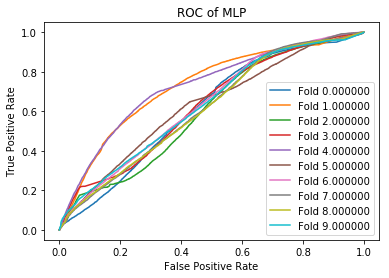

In [11]:
plotROC(rocDF)


In [13]:
#step one, do T test
from scipy import stats

aucDF = pd.DataFrame.from_dict(auc, 'index')
aucDF = aucDF.rename(columns={0:'KNN', 1: 'NB', 2: 'DT', 3:'SVM', 4:'MLP'})

knnList = list(aucDF['KNN'])
gnbList = list(aucDF['NB'])
dtList = list(aucDF['DT'])
svmList = list(aucDF['SVM'])
mplList = list(aucDF['MLP'])


In [14]:
stats.ttest_rel(knnList, mplList) #shows us the bigger picture from the number


Ttest_relResult(statistic=-3.7804263499680326, pvalue=0.004346163092984752)

In [15]:
#box plots of the different points

aucDes = aucDF.describe()


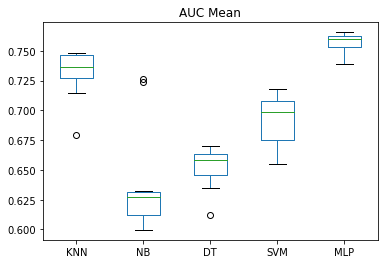

In [16]:
aucMean = pd.Series.to_frame(aucDes.loc[aucDes.index[1]])
aucSTD = pd.Series.to_frame(aucDes.loc[aucDes.index[2]])

aucDF.plot(kind='box', title='AUC Mean', )


# This needs to be saved into its own file eventually....

## Should be done so that I can easily compare the averages from each separate feature section

In [54]:
aucDF


,KNN,NB,DT,SVM,MLP
0,0.725469,0.611819,0.669966,0.667126,0.756135
1,0.743610,0.726558,0.658722,0.717960,0.760048
2,0.737955,0.599647,0.643378,0.654986,0.764234
3,0.735436,0.626987,0.658395,0.706559,0.763177
4,0.747090,0.723979,0.663486,0.716417,0.751994
5,0.747310,0.627859,0.661662,0.707928,0.739363
6,0.731043,0.632226,0.668645,0.701446,0.761068
7,0.748634,0.614475,0.653385,0.696207,0.760180
8,0.679553,0.611083,0.634627,0.676778,0.745126
9,0.714349,0.628332,0.612200,0.674897,0.765657


## This is saving the above table for later comparison

In [55]:
aucDF.to_csv('created_data/AUC_Scores/sentiment_auc.csv', encoding='utf-8')

In [50]:
#Redoing these functions to take in the fold number and then automate the list generation
#default fold number is 10

#take the average of the above list, then look for the best feature set
def getROC(df1, df2, fold=10):
    #section one, prepare data for the learning algorithms
    #divide into equal sections, take 10 total sets from each dataset
    #give proper classifications for each
    foldData = {}
    df1Segs = []
    df2Segs = []
    #add in a parameter for the number of folds to use
    segDF1 = int(len(df1)/fold)
    segDF2 = int(len(df2)/fold)
    
    for i in range(fold):
        foldData[i] = []
        df1Segs.append(i*segDF1)
        df2Segs.append(i*segDF2)

    for i in range(len(df1Segs)):
        #get the fold to fit on
        try:
            fitDF1 = df1[df1Segs[i]:df1Segs[i+1]]
            fitDF2 = df2[df2Segs[i]:df2Segs[i+1]]
            
            predDF1 = pd.concat([df1[:df1Segs[i]], df1[df1Segs[i+1]:]])
            predDF2 = pd.concat([df2[:df2Segs[i]], df2[df2Segs[i+1]:]])
        except IndexError: #Only for the last fold
            fitDF1 = df1[df1Segs[i]:]
            fitDF2 = df2[df2Segs[i]:]
            
            predDF1 = df1[:df1Segs[i]]
            predDF2 = df2[:df2Segs[i]]
            
        #use the DF to get the data
        fitData, fitCls = machLearnData(fitDF1, fitDF2)
        preData, preCls = machLearnData(predDF1, predDF2)
    
        #second one apply all algorithms to it
        #define the algorithms
        neigh = KNClass(n_neighbors=21)
        gnb = GaussianNB()
        dtc = DecisionTreeClassifier(random_state=0)
        vec = svm.SVC(probability=True)
        neur = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

        Algs = [neigh, gnb, dtc, vec, neur]#can add more later, also the order they are added to the dictionary
        
        for alg in Algs:
            alg.fit(fitData, fitCls)
            finCls = alg.predict_proba(preData)
            
            fpr, tpr, thresholds, roc_auc = probaTable(finCls)
            algList = [fpr, tpr, thresholds, roc_auc]
            
            foldData[i].append(algList)
        
    
    return foldData
    
    #get out the ROC curvs and AUC scores for each
    
    
#this will give the proper classifications
#dframe1 should be the positive df
def machLearnData(dframe1, dframe2, rng=0):
    data = []
    #0 = polluters
    #1 = legit
    classify = []
    for index, row in dframe1.iterrows():
        userList = []
        for i in range(len(row)):
            userList.append(row[i])
            
        data.append(userList)
        classify.append(0)
        
    for index, row in dframe2.iterrows():
        userList = []
        for i in range(len(row)):
            userList.append(row[i])

        data.append(userList)
        classify.append(1)
        
    return data, classify

def probaTable(fCls, posL=0, posCut=0.5):
    clsArray = []
    actualCls = []
    
    pos = []
    
    count = 0
    for line in fCls:
        if line[0] >= posCut:
            clsArray.append(0)
        else:
            clsArray.append(1)
        pos.append(line[0])
            
        if count < len(fCls)/2:
            actualCls.append(0)
            count += 1
        else:
            actualCls.append(1)
            
    #print(len(actualCls), len(fCls))
            
    #classTuple = zip(actualCls, fCls)

    fpr, tpr, thresholds = roc_curve(actualCls, pos, pos_label=posL)
    
    roc_auc = auc(fpr, tpr)
    
    #return {'polluter': [truePos, falseNeg], 'legit': [falsePos, trueNeg]}, acc, precision, recall, f1, fpr
    
    return fpr, tpr, thresholds, roc_auc



In [70]:
a = getROC(dfPollutersSent, dfLegitSent, 10)

rocDF = pd.DataFrame.from_dict(a, 'index')
rocDF = rocDF.rename(columns={0:'KNeighborsClassifier', 1: 'GaussianNB', 2: 'DecisionTreeClassifier', 3:'SVM', 4:'MLP'})

In [49]:
aucScores = getAUCScore(rocDF)

In [62]:
#need to make this plot all graphs of all folds
def plotROC(df):
    
    for index, row in df.iterrows():
        for i in range(len(row)):
            fpr = row[i][0]
            tpr = row[i][1]
        
            plt.plot(fpr, tpr,  label="Fold %0.2f" % int(index))
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of MLP')
    plt.legend(loc="lower right")
    plt.show()

In [77]:
rocDF['GaussianNB']

0    [[0.0, 5.57009970478e-05, 5.57009970478e-05, 0...
1    [[0.0, 0.000891215952766, 0.000946916949813, 0...
2    [[0.0, 0.00206093689077, 0.00206093689077, 0.0...
3    [[0.0, 0.000891215952766, 0.00100261794686, 0....
4    [[0.0, 0.000891215952766, 0.000946916949813, 0...
5    [[0.0, 0.00295215284354, 0.00300785384058, 0.0...
6    [[0.0, 0.00278504985239, 0.00278504985239, 0.0...
7    [[0.0, 0.00306355483763, 0.00323065782878, 0.0...
8    [[0.0, 0.00178243190553, 0.00189383389963, 0.0...
9    [[0.0, 0.000222841225627, 0.000278551532033, 0...
Name: GaussianNB, dtype: object

TypeError: '>=' not supported between instances of 'str' and 'float'